<a href="https://colab.research.google.com/github/larasauser/master/blob/main/visualisation_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VISUALISATION

In [1]:
!pip install rasterio tqdm scikit-image scikit-learn piq --quiet

import os
from glob import glob
from datetime import datetime, timedelta
from tqdm import tqdm
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from scipy.linalg import lstsq
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 22.9 MB/s eta 0:00:00
Mounted at /content/drive


In [17]:
from pyproj import Transformer, CRS
import numpy as np

def format_coord_deg(val):
    """Formate les coordonnées en degrés avec 3 décimales pour l'espace"""
    return f'{val:.3f}°'

def add_coords_wgs84(ax, meta, show_y=True):
    """
    Ajoute automatiquement les coordonnées le long des axes en WGS84 (EPSG:4326).
    - show_y : True pour afficher les coordonnées Y (latitude), False sinon
    """
    transform = meta['transform']
    nrows, ncols = meta['height'], meta['width']

    # Indices pour les ticks
    x_idx = np.linspace(0, ncols-1, 5, dtype=int)
    y_idx = np.linspace(0, nrows-1, 5, dtype=int)
    x_pix = transform[2] + x_idx * transform[0]
    y_pix = transform[5] + y_idx * transform[4]

    # Transforme en WGS84 si nécessaire
    raster_crs = CRS(meta['crs'])
    if raster_crs.to_epsg() != 4326:
        transformer = Transformer.from_crs(raster_crs, "EPSG:4326", always_xy=True)
        x_pix, y_pix = transformer.transform(x_pix, y_pix)

    # Applique les ticks X (longitude)
    ax.set_xticks(x_idx)
    ax.set_xticklabels([format_coord_deg(x) for x in x_pix], rotation=45)

    # Applique les ticks Y (latitude) seulement si demandé
    if show_y:
        ax.set_yticks(y_idx)
        ax.set_yticklabels([format_coord_deg(y) for y in y_pix])
    else:
        ax.set_yticks([])

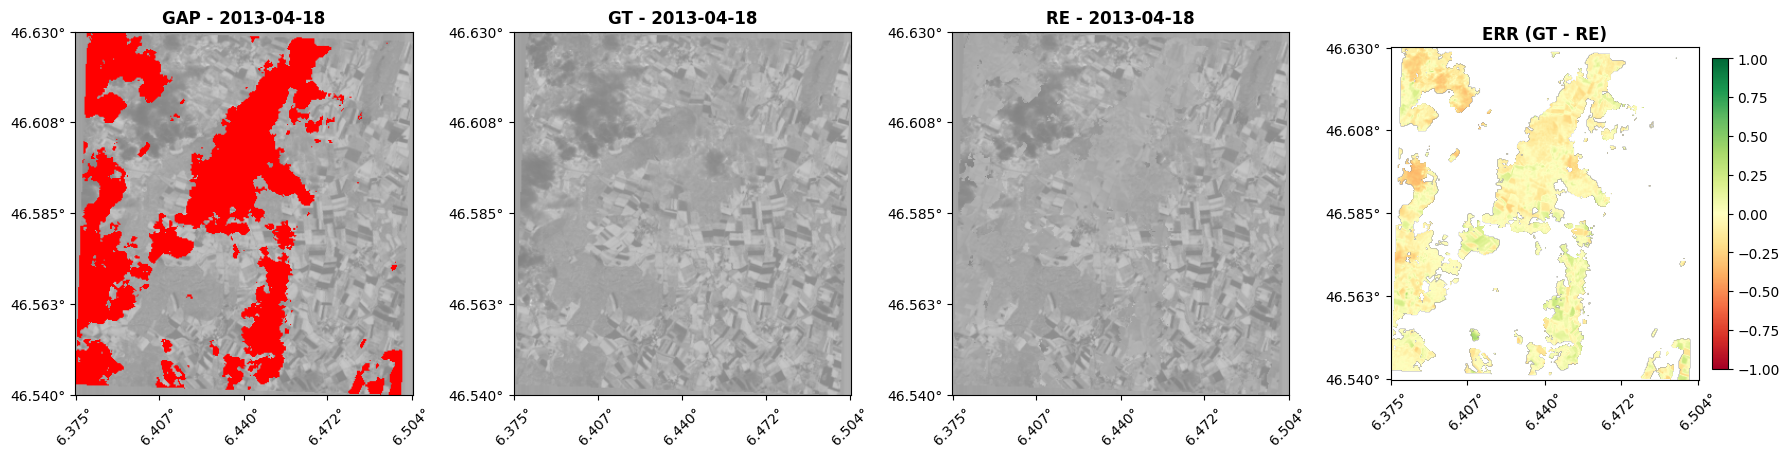

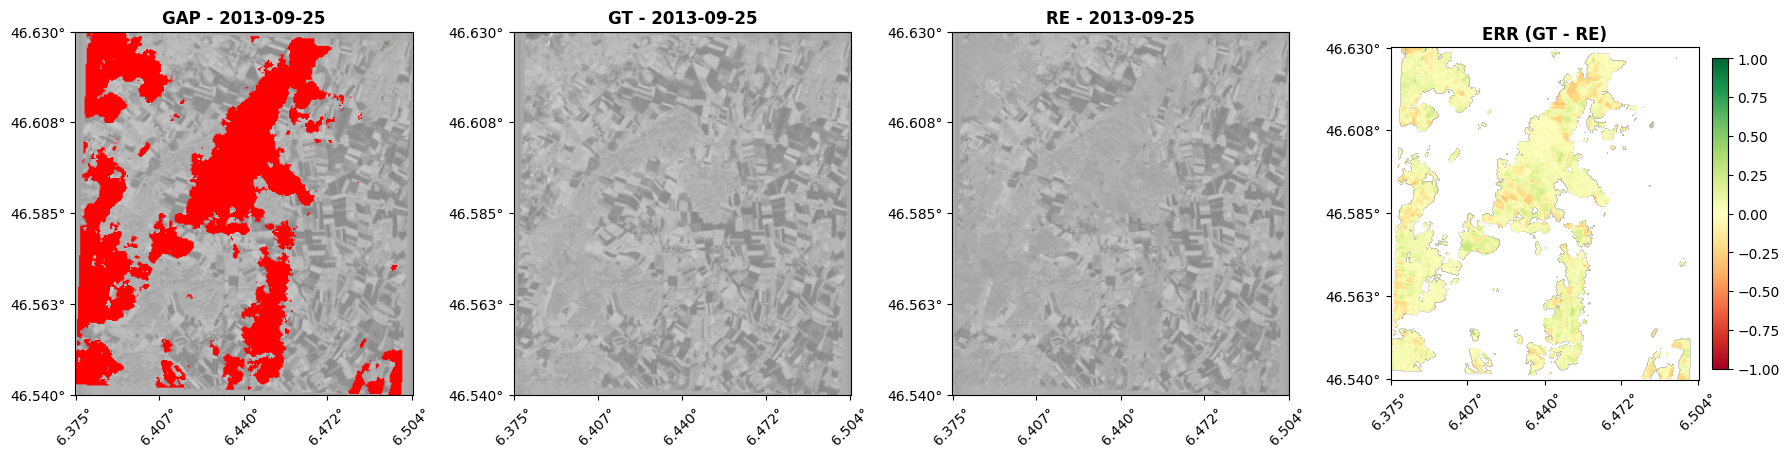

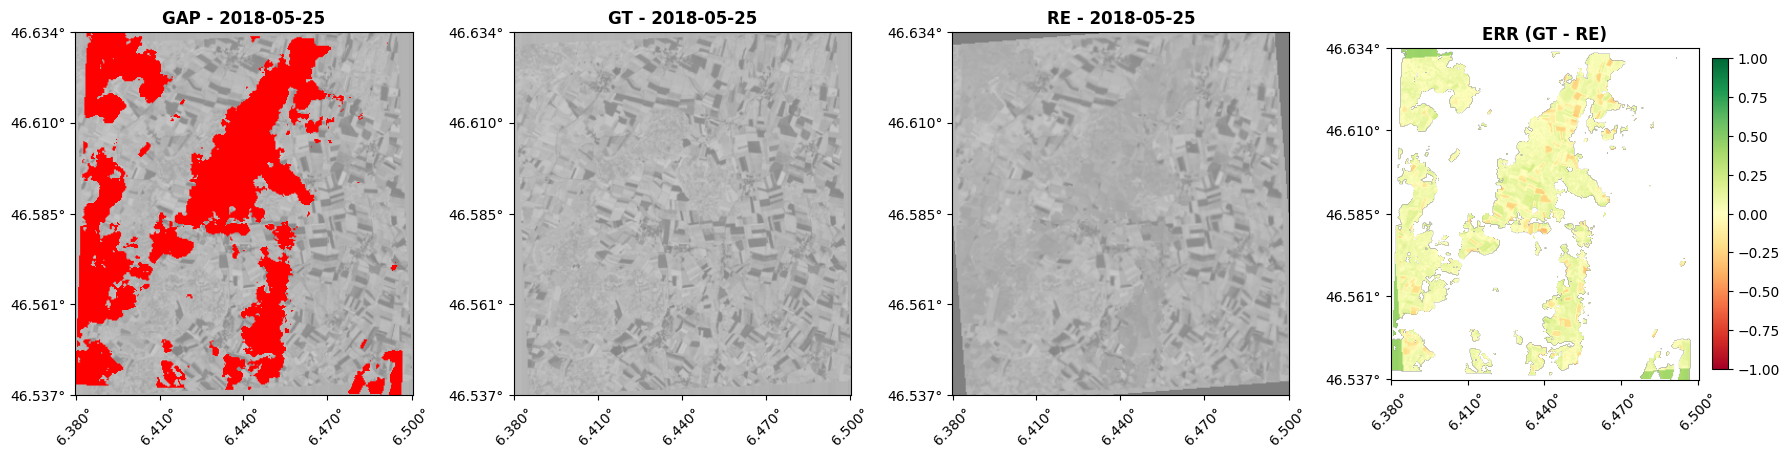

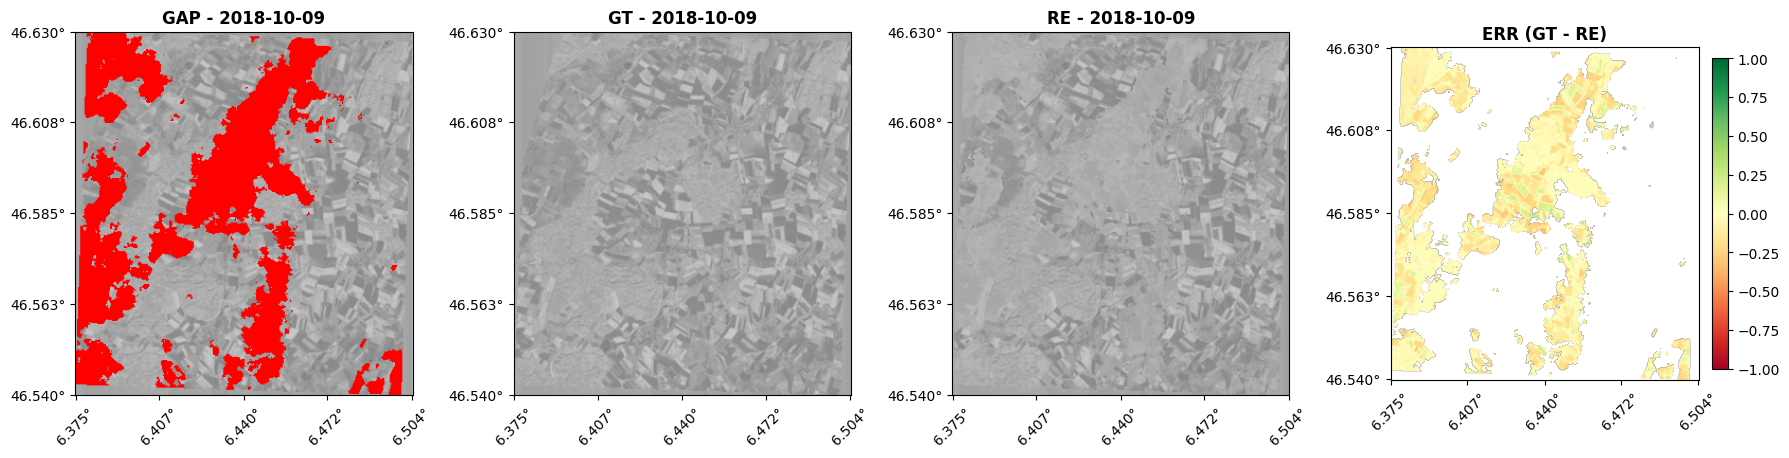

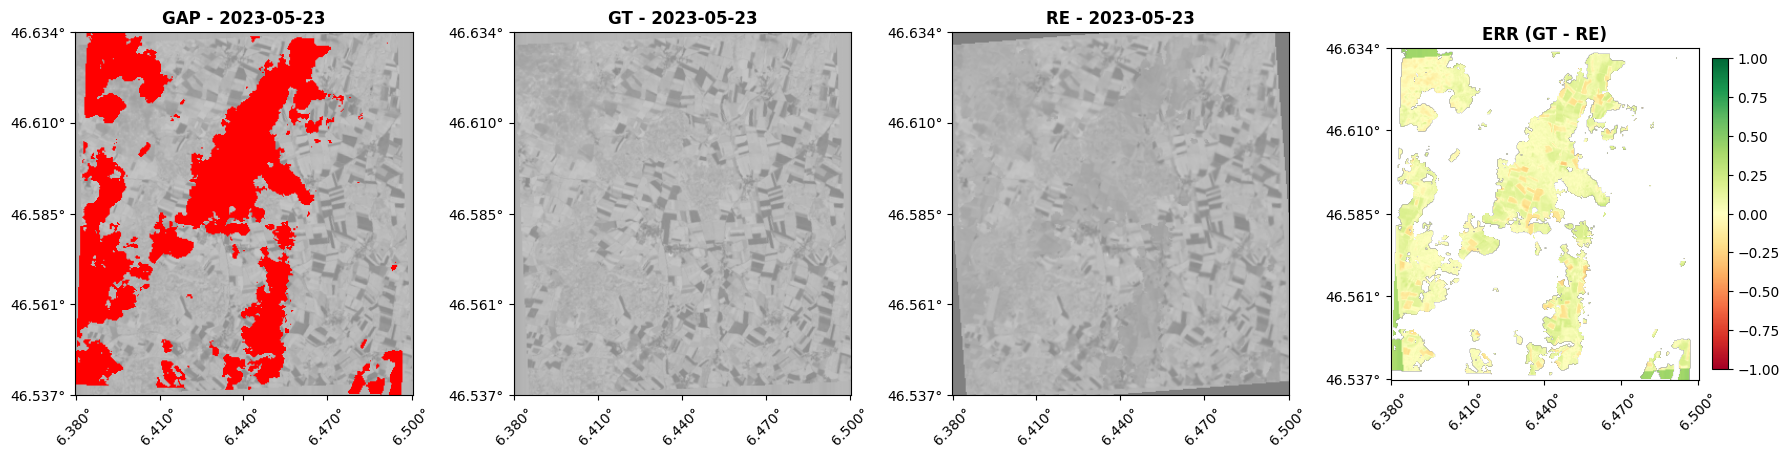

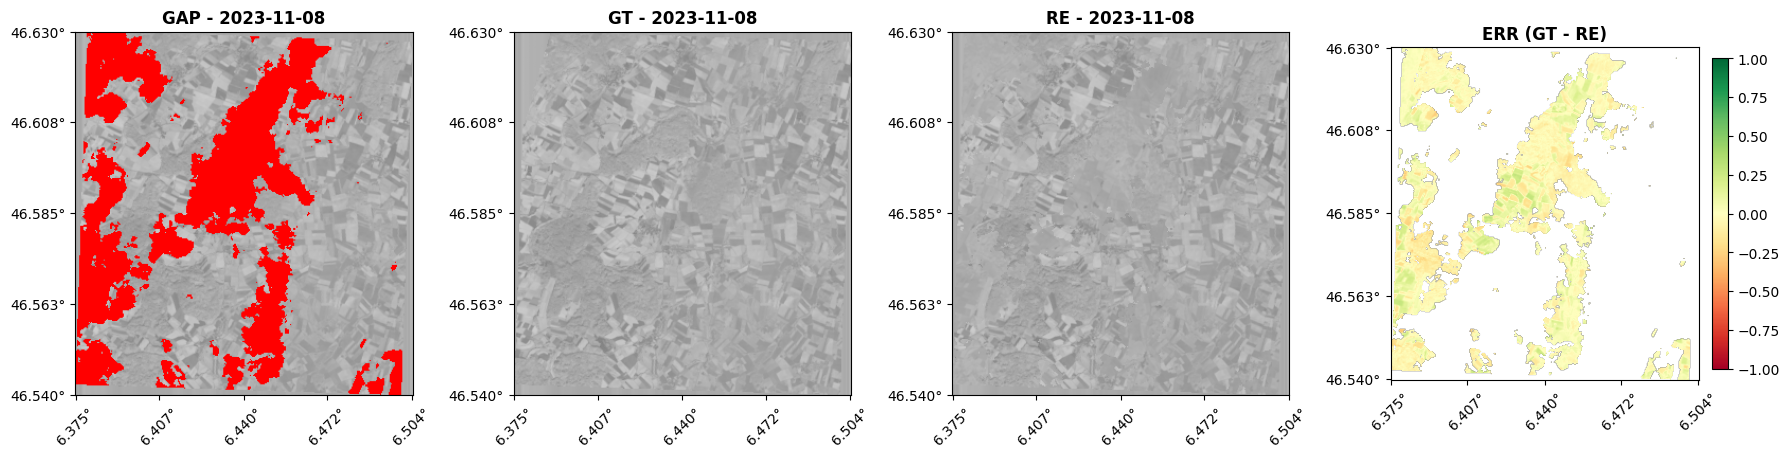

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from rasterio.warp import reproject, Resampling
import rasterio
import os
from glob import glob

# === Dossiers ===
hole_dir = '/content/drive/MyDrive/Whitt/NDVI_grancy_Landsat8_hole'
gt_dir = '/content/drive/MyDrive/Whitt/NDVI_grancy_full'
recon_dir = '/content/drive/MyDrive/Whitt/egfwh_grancy_outputs_optim1'

# === Liste des fichiers ===
hole_files = sorted(glob(os.path.join(hole_dir, '*.tif')))
gt_files = sorted(glob(os.path.join(gt_dir, '*.tif')))
recon_files = sorted(glob(os.path.join(recon_dir, 'recon_*.tif')))

# === Fonctions utilitaires ===
def read_tif_with_meta(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        meta = src.meta.copy()
    arr[arr == meta.get('nodata', -9999)] = np.nan
    return arr, meta

def resample_to_match(source_arr, source_meta, target_meta):
    dst_arr = np.empty((target_meta['height'], target_meta['width']), dtype=np.float32)
    reproject(
        source=source_arr,
        destination=dst_arr,
        src_transform=source_meta['transform'],
        src_crs=source_meta['crs'],
        dst_transform=target_meta['transform'],
        dst_crs=target_meta['crs'],
        resampling=Resampling.bilinear
    )
    return dst_arr

def add_coords(ax, meta):
    """Ajoute les coordonnées réelles le long des axes"""
    transform = meta['transform']
    nrows, ncols = meta['height'], meta['width']

    # Calcul des coordonnées aux bords
    x_coords = [transform[2] + transform[0]*i for i in range(0, ncols, max(1,ncols//5))]
    y_coords = [transform[5] + transform[4]*i for i in range(0, nrows, max(1,nrows//5))]

    ax.set_xticks(np.linspace(0, ncols-1, len(x_coords)))
    ax.set_xticklabels([f'{x:.2f}' for x in x_coords], rotation=45)
    ax.set_yticks(np.linspace(0, nrows-1, len(y_coords)))
    ax.set_yticklabels([f'{y:.2f}' for y in y_coords])

# === Visualisation ===
for i in range(len(hole_files)):
    fname = os.path.basename(hole_files[i])
    date = fname.replace('NDVI_', '').replace('.tif', '')

    # Lecture de l'image trouée (référence)
    hole, hole_meta = read_tif_with_meta(hole_files[i])

    # Lecture et alignement des GT et reconstruction
    gt, gt_meta = read_tif_with_meta(gt_files[i])
    gt_resampled = resample_to_match(gt, gt_meta, hole_meta)

    recon, recon_meta = read_tif_with_meta(recon_files[i])
    recon_resampled = resample_to_match(recon, recon_meta, hole_meta)

    # Crée un masque des gaps (NaN dans hole)
    gap_mask = np.isnan(hole)

    # Calcul de l'erreur uniquement sur les pixels des gaps
    err = np.full_like(hole, np.nan)
    valid_mask = gap_mask & ~np.isnan(gt_resampled) & ~np.isnan(recon_resampled)
    err[valid_mask] = gt_resampled[valid_mask] - recon_resampled[valid_mask]

    # === Figure ===
    fig, axs = plt.subplots(1, 4, figsize=(18, 5))

    # === Colormap grise avec NaN en rouge ===
    cmap_gray_red = plt.cm.gray
    cmap_gray_red.set_bad(color='red')

    # 1) GAP
    im0 = axs[0].imshow(np.ma.masked_invalid(hole), cmap=cmap_gray_red, vmin=-1, vmax=1)
    axs[0].set_title(f'GAP - {date}', fontweight='bold')
    add_coords_wgs84(axs[0], hole_meta)

    # 2) GT
    im1 = axs[1].imshow(np.ma.masked_invalid(gt_resampled), cmap=cmap_gray_red, vmin=-1, vmax=1)
    axs[1].set_title(f'GT - {date}', fontweight='bold')
    add_coords_wgs84(axs[1], hole_meta)

    # 3) Reconstruction
    im2 = axs[2].imshow(np.ma.masked_invalid(recon_resampled), cmap=cmap_gray_red, vmin=-1, vmax=1)
    axs[2].set_title(f'RE - {date}', fontweight='bold')
    add_coords_wgs84(axs[2], hole_meta)

    # 4) Erreur (GT - RE)
    im4 = axs[3].imshow(np.ma.masked_invalid(err), cmap='RdYlGn', vmin=-1, vmax=1)
    axs[3].set_title('ERR (GT - RE)', fontweight='bold')
    add_coords_wgs84(axs[3], hole_meta)
    plt.colorbar(im4, ax=axs[3], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

In [4]:
!pip install piq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 3.4 MB/s eta 0:00:00


In [10]:
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import reproject, Resampling
from sklearn.metrics import mean_squared_error, r2_score
import torch
import piq
from glob import glob

# === Dossiers ===
hole_dir = '/content/drive/MyDrive/Whitt/NDVI_herens_Landsat8_hole'
gt_dir = '/content/drive/MyDrive/Whitt/NDVI_herens_full'
recon_dir = '/content/drive/MyDrive/Whitt/egfwh_herens_outputs_optim1'

# === Liste des fichiers ===
hole_files = sorted(glob(os.path.join(hole_dir, '*.tif')))
gt_files = sorted(glob(os.path.join(gt_dir, '*.tif')))
recon_files = sorted(glob(os.path.join(recon_dir, 'recon_*.tif')))

# === Fonctions utilitaires ===
def read_tif_with_meta(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        meta = src.meta.copy()
    arr[arr == meta.get('nodata', -9999)] = np.nan
    return arr, meta

def resample_to_match(source_arr, source_meta, target_meta):
    """Reprojette et recadre une image pour matcher une autre."""
    dst_arr = np.empty((target_meta['height'], target_meta['width']), dtype=np.float32)
    reproject(
        source=source_arr,
        destination=dst_arr,
        src_transform=source_meta['transform'],
        src_crs=source_meta['crs'],
        dst_transform=target_meta['transform'],
        dst_crs=target_meta['crs'],
        resampling=Resampling.bilinear
    )
    return dst_arr

# === Fonction metrics ===
def evaluate_metrics(gt_img, recon_img, gap_mask, image_name):
    """
    Calcul des metrics uniquement sur les pixels manquants (gap_mask = True)
    """
    valid_mask = gap_mask & ~np.isnan(gt_img) & ~np.isnan(recon_img)
    if np.sum(valid_mask) == 0:
        return pd.DataFrame([{
            'Image name': image_name,
            'RMSE': np.nan, 'R²': np.nan, 'MAE': np.nan,
            'MS-SSIM': np.nan, '% reconstructed pixels': 0.0
        }])

    y_true = gt_img[valid_mask]
    y_pred = recon_img[valid_mask]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred) if np.var(y_true) > 1e-8 else np.nan
    mae = np.mean(np.abs(y_true - y_pred))

    # Normalisation pour MS-SSIM uniquement sur pixels valides
    min_val = np.min([y_true.min(), y_pred.min()])
    max_val = np.max([y_true.max(), y_pred.max()])
    if max_val - min_val < 1e-8:
        ms_ssim_score = np.nan
    else:
        gt_norm = (gt_img - min_val) / (max_val - min_val)
        recon_norm = (recon_img - min_val) / (max_val - min_val)
        gt_norm[~valid_mask] = 0.0
        recon_norm[~valid_mask] = 0.0
        gt_tensor = torch.from_numpy(gt_norm).unsqueeze(0).unsqueeze(0).float()
        recon_tensor = torch.from_numpy(recon_norm).unsqueeze(0).unsqueeze(0).float()
        ms_ssim_score = piq.multi_scale_ssim(gt_tensor, recon_tensor, data_range=1., reduction='none').item()

    coverage = (np.sum(valid_mask) / np.sum(gap_mask)) * 100 if np.sum(gap_mask) > 0 else 0.0

    results = {
        'Image name': image_name,
        'RMSE': rmse,
        'R²': r2,
        'MAE': mae,
        'MS-SSIM': ms_ssim_score,
        '% reconstructed pixels': coverage
    }
    return pd.DataFrame([results])

# === Calcul des metrics pour toutes les images ===
all_results = []

for hole_path in hole_files:
    fname = os.path.basename(hole_path)
    date_str = fname.replace('NDVI_', '').replace('.tif', '')

    # Lecture et alignement de l'image trouée
    hole_img, hole_meta = read_tif_with_meta(hole_path)

    # Ground truth
    gt_path = [f for f in gt_files if date_str in f][0]
    gt_img, gt_meta = read_tif_with_meta(gt_path)
    gt_resampled = resample_to_match(gt_img, gt_meta, hole_meta)

    # Reconstruction
    recon_path = [f for f in recon_files if date_str in f][0]
    recon_img, recon_meta = read_tif_with_meta(recon_path)
    recon_resampled = resample_to_match(recon_img, recon_meta, hole_meta)

    # Gap mask (pixels manquants dans l'image trouée)
    gap_mask = np.isnan(hole_img)

    # Metrics
    df = evaluate_metrics(gt_resampled, recon_resampled, gap_mask, fname)
    all_results.append(df)

# Table finale
metrics_table = pd.concat(all_results, ignore_index=True)
metrics_table

AttributeError: module 'sympy' has no attribute 'printing'